### Constant Range

策略：初始的时候选定一个价格范围，之后就不再调整。

根据初始的时候如何选择价格范围，又可以分为很多策略：

    1. 以当前价格为中心，选定一个固定长度的价格范围(这个策略相当于part3_activeAdjustment在首次提供之后不再调整)

    2. 参考池子内流动性的分布图，以分布最多的价格为中心，选择一个固定长度的价格范围
        如何获得池子内流动性的分布图？
            暴力的算法是获取池子里所有的mint和burn事件，加总到每一个tick上

    3. 计算出池子价格的时间加权价格，以当前的时间加权价格为中心，选择一个固定长度的价格范围

    4. 基于布林带
        选择布林带的上轨线作为价格上限，下轨线作为价格下限，作为价格范围。
    等等

In [96]:
import sys
sys.path.append("..") 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from importlib import reload
from poolData import swapData
from utils import utils
reload(swapData)
reload(utils)

query = swapData.SwapDataQuery()
utils = utils.utils()

* * *
### 1 以当前价格为中心，选择固定长度的tick range
    直接在part3里改，不放在这里了

### 2 以流动性最密集价格为中心，选择固定长度的tick range


In [13]:
begin = datetime(2023, 3, 19)
# begin的时候，区块高度差不多是16868192
block = 16868192

In [14]:
# 先计算流动性的分布，还好the graph支持了查询一个tick的liquidity，不用自己暴力算了
pool_id = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
tick_data = query.query_tick_liquidities(poolAddress=pool_id, block=block)
tick_data

None {'data': {'ticks': [{'id': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#100', 'liquidityGross': '100'}, {'id': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#102310', 'liquidityGross': '17093244380199'}, {'id': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108340', 'liquidityGross': '2266789968'}, {'id': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108360', 'liquidityGross': '2273693713'}, {'id': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108390', 'liquidityGross': '44739669244'}, {'id': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108460', 'liquidityGross': '0'}, {'id': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#110', 'liquidityGross': '100'}, {'id': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#115120', 'liquidityGross': '144810683332502'}, {'id': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#115140', 'liquidityGross': '0'}, {'id': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#122720', 'liquidityGross': '0'}, {'id': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#122840', 'liquidityGross': '0'}

,id,liquidityGross
0,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#100,100
1,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#102310,17093244380199
2,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108340,2266789968
3,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108360,2273693713
4,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108390,44739669244
...,...,...
2715,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#-88...,2128374373681327
2716,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#92110,25157895928880
2717,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#-92110,398290794261
2718,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#95810,830863045158786350


In [15]:
tick_data

,id,liquidityGross
0,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#100,100
1,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#102310,17093244380199
2,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108340,2266789968
3,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108360,2273693713
4,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108390,44739669244
...,...,...
2715,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#-88...,2128374373681327
2716,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#92110,25157895928880
2717,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#-92110,398290794261
2718,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#95810,830863045158786350


In [16]:
# 处理一下id，#后的数字应该是tick index
tick_data["tick_index"] = tick_data["id"].str.split("#").str.get(1)
tick_data["tick_index"] = tick_data["tick_index"].astype(int)
tick_data["liquidityGross"] = tick_data["liquidityGross"].astype(float)
tick_data.dropna()
tick_data = tick_data[["tick_index", "liquidityGross"]]

In [17]:
tick_data.sort_values("tick_index", inplace=False)

,tick_index,liquidityGross
2715,-887270,2.128374e+15
2713,-875030,0.000000e+00
2684,-460540,0.000000e+00
2587,-332730,0.000000e+00
1582,-202860,0.000000e+00
...,...,...
2685,575680,0.000000e+00
2688,644760,0.000000e+00
2696,736860,0.000000e+00
2701,759890,3.982908e+11


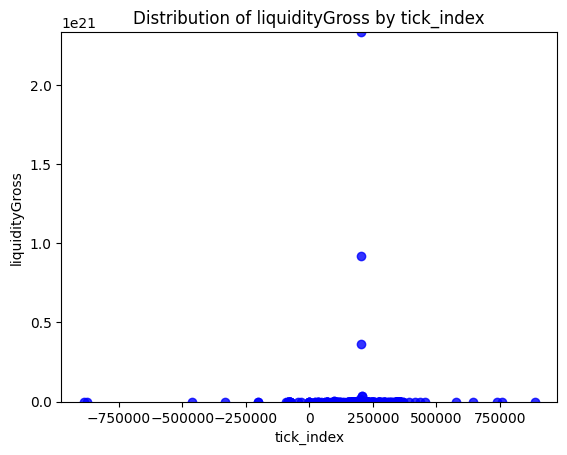

In [18]:
# 设置柱状图的颜色和透明度
color = 'blue'
alpha = 0.8

# 绘制柱状图
plt.scatter(tick_data['tick_index'], tick_data['liquidityGross'], color=color, alpha=alpha)

# 设置横纵坐标的标签和标题
plt.xlabel('tick_index')
plt.ylabel('liquidityGross')
plt.title('Distribution of liquidityGross by tick_index')

# 设置y轴的刻度范围
plt.ylim([0, max(tick_data['liquidityGross'])])

# 显示图形
plt.show()
# todo 分布图画好看点


In [56]:
grouped_df = tick_data.groupby(['tick_index'])['liquidityGross'].sum().reset_index()
grouped_df = grouped_df.sort_values(by="liquidityGross", ascending=False)
# 选择流动性最多的一个tick做为中心
centre_tick = grouped_df["tick_index"].iloc[0]
tickLower = centre_tick - 800
tickUpper = centre_tick + 800

In [57]:
grouped_df

,tick_index,liquidityGross
1603,202650,2.336329e+21
1602,202640,9.218549e+20
1604,202660,3.671025e+20
1940,206020,3.253635e+19
1939,206010,3.253182e+19
...,...,...
192,184470,0.000000e+00
1634,202960,-4.816353e+16
1625,202870,-9.503482e+17
1649,203110,-9.503482e+17


In [197]:
# 选好了头寸价格范围之后用一样的方法来计算fee
pool_id = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
query.query_positions(pool_id=pool_id, block_gte=16859000, limit=10, orderBy="owner")
decimal0 = 6
decimal1 = 18
# 初始头寸的美元价值
initial_position = 100000

# 选定时间
begin = datetime(2023, 3, 19)
end = datetime.now()

# 计算价格范围
price_low = utils.tickIndex2Price(tickLower)
price_upper = utils.tickIndex2Price(tickUpper)
print("this is the lower price: ", price_low)
print("this is the upper price: ", price_upper)
# 先把tick price转换成sqrtX96的形式
sqrt_p_lower = (price_low ** 0.5) * (2 ** 96)
sqrt_p_upper = (price_upper ** 0.5) * (2 ** 96)
sqrt_p_lower_f = '{:.0f}'.format(sqrt_p_lower)
sqrt_p_upper_f = '{:.0f}'.format(sqrt_p_upper)
# 获取swaps
# swaps = query.query_swaps(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id, sqrtPriceX96_gte=sqrt_p_lower_f, sqrtPriceX96_lte=sqrt_p_upper_f)
swaps = query.query_swaps(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id)

In [135]:
swaps

,id,timestamp,sender,recipient,origin,amount0,amount1,amountUSD,sqrtPriceX96,tick,logIndex,price,current_position0,current_position1
7629,0x0861d00acafcd74202e82741c031db7417fbca4c45fe...,1679155223,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xe63df014b8481ecc14582ff09e88809b0ad4e5a9,0xe63df014b8481ecc14582ff09e88809b0ad4e5a9,-17615.76052,9.835103915662891668,17613.78905750513568184175674883613,1.871596e+33,201409.0,17,5.580399e+08,5.873304e+11,3.277538e+20
5525,0x060ca03d50d79c0196c3b46dcbebb3dfef605b4f815e...,1679155343,0xe592427a0aece92de3edee1f18e0157c05861564,0x9008d19f58aabd9ed0d60971565aa8510560ab41,0xbff9a1b539516f9e20c7b621163e676949959a66,5994.484682,-3.349237752536633017,5995.99888113471748052423946471036,1.873201e+33,201426.0,168,5.589973e+08,5.868272e+11,3.280348e+20
615,0x00a4333a3aad92b9579333e786936077d987a2022a6f...,1679155355,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xa62a7a20c38fd87d0ba3f06bfc84a3bce7596120,619.1124,-0.345987404437934662,619.337728969297592786277072330285,1.873413e+33,201428.0,299,5.591236e+08,5.867609e+11,3.280719e+20
3614,0x03e42477118de94353fb49e5bf560cbcfdfc1f0a400e...,1679155475,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xd2628b911b5f4a179767bdf78ae23300f6b8e412,0xd2628b911b5f4a179767bdf78ae23300f6b8e412,-163537.133213,91.415378642642385982,163617.7767337577673867614055776218,1.872815e+33,201422.0,22,5.587670e+08,5.869481e+11,3.279672e+20
6742,0x076030fcb780f6eed61619f31cc70eb914dc44d0c3f9...,1679155499,0xf8b721bff6bf7095a0e10791ce8f998baa254fd0,0xf8b721bff6bf7095a0e10791ce8f998baa254fd0,0xdd8ef55055e01d39cb87571bd38c43ab9b5903a5,739093.979647,-412.741987190537950232,739097.5636931547528966010273888095,1.872302e+33,201417.0,2,5.584606e+08,5.871091e+11,3.278773e+20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,0x02c686b47698b54f765326954584e365ab2de1676b3b...,1682579675,0x9a7e631181f38384737eb39ef9a39a747be4fe56,0x9a7e631181f38384737eb39ef9a39a747be4fe56,0x55a37a2e5e5973510ac9d9c723aec213fa161919,-77330.515142,41.029842822954423483,77265.4495100228929069283674830174,1.824582e+33,200900.0,53,5.303559e+08,6.024644e+11,3.195205e+20
8376,0x092c4a1dd84fedda4b7822415521036281325968baa6...,1682579939,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x8f14651d9cfbc9215ed3c22d637c891f853921d3,649.870039,-0.344297532679138802,648.997392874494252411724740071945,1.824071e+33,200895.0,215,5.300594e+08,6.026329e+11,3.194312e+20
2083,0x024203c327b9773e38990dfbbecf898e01fb1dcdef32...,1682580035,0x280027dd00ee0050d3f9d168efd6b40090009246,0x280027dd00ee0050d3f9d168efd6b40090009246,0xa70295e6dbf88f2ab9b9e44705a678f81d1d9c52,-116253.180779,61.691915340066758656,116192.7297183332813348730195526875,1.824776e+33,200902.0,22,5.304688e+08,6.024003e+11,3.195545e+20
8677,0x0980f9eda2f2a971a30cd6ff69eed3ebbde7d5163650...,1682580767,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x9223f4702d712f6a0a8b2c8671e1f66be6cbad21,1000,-0.530285362798563429,999.1192701761392326691082139967485,1.824916e+33,200904.0,138,5.305501e+08,6.023541e+11,3.195790e+20


In [142]:
swaps1 = swaps

In [210]:
swaps1 = swaps
swaps1['tick'] = swaps1['tick'].astype(int)
# 筛选swaps的条件：swap后最终的tick在我们的头寸tick之内
condition = (swaps1['tick'] > tickLower) & (swaps1['tick'] < tickUpper)
# 筛选
print("total swaps: \n", swaps.shape[0])
swaps1 = swaps1[condition]
print("total swaps in range: \n", swaps1.shape[0])
# 这个策略选择出来的tick index有点问题。为什么这么多swap竟然都不在流动性最多的tick之内（可能是特殊情况 todo：处理一下）

total swaps: 
 18000
total swaps in range: 
 126


In [211]:
swaps1

,id,timestamp,sender,recipient,origin,amount0,amount1,amountUSD,sqrtPriceX96,tick,logIndex,price,current_position0,current_position1
12396,0x0d967733f8a318751b12bc7f3534d1d4e411fe472251...,1680613919,0xa69babef1ca67a37ffaf7a485dfff3382056e78c,0xa69babef1ca67a37ffaf7a485dfff3382056e78c,0x6046945c5b5ef5933b8e73a98a6ad7bf3e031df7,-555826.330220,296.438450,556437.961982,1.829616e+33,200955,172,5.332866e+08,9.999459e+14,5.332578e+23
1467,0x018b71fa683d70c20a4ded5377a5781a7e392aac646a...,1680613919,0xe8cfad4c75a5e1caf939fd80afcf837dde340a69,0xe8cfad4c75a5e1caf939fd80afcf837dde340a69,0x24f7ef98522dd61d529464f67bb3ffe96ea8afc2,-512410.378622,273.277021,513092.667509,1.829564e+33,200955,25,5.332566e+08,9.999741e+14,5.332427e+23
1353,0x016ebdba6647abc5b317ec7e0ba719383b8e2e1c2c18...,1680613991,0x1d620454f3a2b17a09aeaa851f77573883505118,0x131d57011a5eee154914e0c5efb09a21bdea7191,0x131d57011a5eee154914e0c5efb09a21bdea7191,-561.909527,0.299700,562.544016,1.829284e+33,200952,384,5.330934e+08,1.000127e+15,5.331612e+23
10781,0x0bd09f000d5131b2b2b19b1f5bfb5ed96e6bb74cd059...,1680614051,0xe4000004000bd8006e00720000d27d1fa000d43e,0xe4000004000bd8006e00720000d27d1fa000d43e,0xa06c3c08a19e51b33309eddfb356c33ead8517a3,-22488.371141,12.000000,22519.030517,1.829727e+33,200956,56,5.333514e+08,9.998852e+14,5.332901e+23
994,0x011034c1b9e9f1fb274cfff97c9ab54ed62ba164a6ee...,1680614051,0xdecf04ca46d287b3cb99692ad512e568ba276140,0x84d99aa569d93a9ca187d83734c8c4a519c4e9b1,0x1739b308d2232f9987975298c4459b5e51fa272e,5355.308181,-2.854821,5359.959773,1.829720e+33,200956,140,5.333471e+08,9.998892e+14,5.332880e+23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,0x022ea197bb3616181e3f8b9ca7a325ba3bea94edd5cb...,1682500871,0xe592427a0aece92de3edee1f18e0157c05861564,0xdef171fe48cf0115b1d80b88dc8eab59176fee57,0xe9928b2c1253f8b938d9aad2f4c3854c33d8bb46,9085.802013,-4.842463,9081.574218,1.829529e+33,200954,316,5.332359e+08,9.999935e+14,5.332324e+23
1968,0x0220e552071c46753ca4b53e467d7b537d517b0828f0...,1682537927,0x280027dd00ee0050d3f9d168efd6b40090009246,0x280027dd00ee0050d3f9d168efd6b40090009246,0x9d0427999382946412f103c5d332aa05b4035f10,-778116.342354,414.687085,779406.989722,1.829386e+33,200953,2,5.331526e+08,1.000072e+15,5.331908e+23
5339,0x05d56bd53f945ab53a9b6192c78375f9eef0a2285469...,1682546927,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x62cdced524ba6c9d023c0b8682e835af6aba44fc,0x62cdced524ba6c9d023c0b8682e835af6aba44fc,-101470.460281,54.112440,101469.593176,1.829257e+33,200951,273,5.330776e+08,1.000142e+15,5.331532e+23
7892,0x08aa10492badc3dc128879d4cd63ecc1f515de9a158e...,1682547683,0x1111111254eeb25477b68fb85ed929f73a960582,0x08b37ae30fd0f6f086e45132c847c59dccaf2969,0x08b37ae30fd0f6f086e45132c847c59dccaf2969,-7121.307341,3.799652,7123.104546,1.829636e+33,200955,189,5.332985e+08,9.999347e+14,5.332637e+23


In [199]:
# position info
# 选定池子： token0: usdc(decimal: 6), token1: weth(decimal: 18)
pool_id = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
decimal0 = 6
decimal1 = 18
# 初始头寸的美元价值
initial_position = 100000

# 选定时间 
begin = datetime(2023, 3, 19)
end = datetime.now()

token0_amount = initial_position / 2
# 计算token1数量的时候需要知道价格
# 获取价格
liquidity_data = query.query_liquidity(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id="0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640")
liquidity_data

In [203]:
price_begin = utils.sqrtPrice2Price(int(liquidity_data["sqrtPrice"][0]))
price_end = utils.sqrtPrice2Price(int(liquidity_data["sqrtPrice"][liquidity_data.shape[0]-1]))
price_begin_real = utils.price2RealPrice(price_begin, decimal0=decimal0, decimal1=decimal1)
price_end_real = utils.price2RealPrice(price_end, decimal0=decimal0, decimal1=decimal1)
# 拿到价格之后才可以计算初始头寸
token1_amount = token0_amount * price_begin_real
token1_amount

27.904097419391654

In [213]:
swaps1 = swaps

In [214]:
# 计算liquidity
price_low = utils.tickIndex2Price(tickLower)
price_upper = utils.tickIndex2Price(tickUpper)
l = utils.calculateLiquidity(token0_amount=token0_amount * decimal0, token1_amount=token1_amount * decimal1, price_low=price_low, price_upper=price_upper, decimal0=decimal0, decimal1=decimal1)
# 筛选出在range内的所有交易
swaps1["price"] = swaps1["sqrtPriceX96"].astype(float)
swaps1["sqrtPriceX96"] = swaps1["price"].astype(float)

swaps1["price"] = swap2["sqrtPriceX96"].apply(lambda x: utils.sqrtPrice2Price(x))
swaps1["current_position0"] = utils.calculate_current_position0(l, swaps1["price"])
swaps1["current_position1"] = utils.calculate_current_position1(l, swaps1["price"])

# 计算fee
# convert str into float
swaps1['amount0'] = swaps['amount0'].astype(float)
swaps1['amount1'] = swaps['amount1'].astype(float)
swaps1['amountUSD'] = swaps['amountUSD'].astype(float)
swaps1['sqrtPriceX96'] = swaps['sqrtPriceX96'].astype(float)
swaps1['tick'] = swaps['tick'].astype(int)
swaps1['logIndex'] = swaps['logIndex'].astype(int)

# 先把不用的列去掉
swaps1 = swaps1.drop(swaps1.columns[[0, 2, 3, 4, 7, 10]], axis = 1)
swaps1.head(6)

,timestamp,amount0,amount1,sqrtPriceX96,tick,price,current_position0,current_position1
7629,1679155223,-17615.760520,9.835104,1.871596e+33,201409,5.580399e+08,9.775168e+14,5.454933e+23
5525,1679155343,5994.484682,-3.349238,1.873201e+33,201426,5.589973e+08,9.766794e+14,5.459611e+23
615,1679155355,619.112400,-0.345987,1.873413e+33,201428,5.591236e+08,9.765690e+14,5.460228e+23
3614,1679155475,-163537.133213,91.415379,1.872815e+33,201422,5.587670e+08,9.768806e+14,5.458486e+23
6742,1679155499,739093.979647,-412.741987,1.872302e+33,201417,5.584606e+08,9.771485e+14,5.456990e+23
9786,1679155631,237199.265575,-132.197541,1.870727e+33,201400,5.575216e+08,9.779710e+14,5.452400e+23


In [216]:
swaps1['tick'] = swaps1['tick'].astype(int)
# 筛选swaps的条件：swap后最终的tick在我们的头寸tick之内
condition = (swaps1['tick'] > tickLower) & (swaps1['tick'] < tickUpper)
# 筛选
print("total swaps: \n", swaps.shape[0])
swaps1 = swaps1[condition]
print("total swaps in range: \n", swaps1.shape[0])

total swaps: 
 18000
total swaps in range: 
 126


In [167]:
liquidity_raw = liquidity_data
liquidity_raw

,periodStartUnix,liquidity,sqrtPrice,token0Price,token1Price,tick,feeGrowthGlobal0X128,feeGrowthGlobal1X128,tvlUSD,volumeToken0,volumeToken1,volumeUSD,feesUSD,txCount,open,high,low,close
0,1679158800,31691854789759819627,1871666948661873416199899917784088,1791.851542392230339967547914533666,0.0005580819483878331967604985081167192,201410,2314975469199928457298700227744982,1111162292302232016625192018264273618935405,362517939.1226720089381000671278629,0,0,0,0,372,1798.390894813620679474180985197866,1803.236399827628569085607995221095,1769.953587075568576406795835267567,1791.851542392230339967547914533666
1,1679162400,32915185914729732691,1867893400320714844515651086096830,1799.098710137099104209582500255936,0.0005558338707962253356429190522474716,201369,2315038215475779131181192686558395,1111189202831556094328153678234461295869361,363811618.6075028876192885997227013,0,0,0,0,366,1790.640320160079804025064362917098,1799.108571408040728063168297875355,1786.686354081499257894742581324593,1799.098710137099104209582500255936
2,1679166000,34369179026466248085,1869482743679436927327266292647007,1796.040997899866322473028892703993,0.0005567801632419932350116030494839081,201386,2315126854003039415933596971303595,1111241826769754789231620166343530092470985,363967492.8611761592527996744286012,0,0,0,0,333,1799.099225334904656531075427168004,1809.622901299084675474781496124223,1794.120699231514675114167039962852,1796.040997899866322473028892703993
3,1679169600,34183163223601833767,1868781276195693273308669229878293,1797.389578204559120182790388692096,0.000556362411424970994583196746389777,201379,2315168855482994101747218874079807,1111263525863761589158339866419647898430929,363205815.9317762712257394030005428,0,0,0,0,317,1796.054690522833853305120372567828,1805.57781837591635090288239389413,1792.725482994450340228488201862034,1797.389578204559120182790388692096
4,1679173200,34246952167731560476,1875752556320845172108591732547304,1784.054320332921814271944303424757,0.0005605210495011106585938907612211571,201453,2315193497548537858877306471738285,1111292420021385719852093400706179840724576,360909125.4200933323216227809336806,0,0,0,0,309,1797.199358810234823401563218695319,1797.220201287329445413990798860576,1783.038903387140753714413070004309,1784.054320332921814271944303424757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,1682600400,22185919446316182651,1825136231277784495762018273633886,1884.380470098911815972996618446511,0.0005306783931737042660145787961465196,200906,2358829393676081247194915336841830,1134596891322118805041421372900168521904409,473553617.5637961709830965829040443,0,0,0,0,210,1877.340691682668542409176121555191,1893.840838469430203643843091473679,1877.340691682668542409176121555191,1884.380470098911815972996618446511
957,1682604000,22286084309801107058,1824702653916277603466925547177780,1885.276091946508441708694843177566,0.0005304262883679391234350168877426455,200901,2358877877031953273959837265813358,1134621689834707797162720969719311080058246,473742256.1458241181864821795522302,0,0,0,0,267,1886.092185191155060843571834907745,1895.579359751841284674003479706827,1883.602623103541769142499952389578,1885.276091946508441708694843177566
958,1682607600,58340783645692034209,1817827053177885532545370884046642,1899.56449153878885810498920064819,0.0005264364565953354108503192288252696,200826,2358988492821227362584982158788859,1134665161624709044034692081775444140249201,474896065.9096427176596920320147553,0,0,0,0,287,1885.756113159180006543284233007343,1912.383654929418007763121489324687,1885.756113159180006543284233007343,1899.56449153878885810498920064819
959,1682611200,58435191525936819152,1817660059984692722266596562244377,1899.913543508139805741469283501972,0.0005263397397302229909413667393812322,200824,2359023645914321269395838006627223,1134683741470596630066755027166221496766395,475277810.9587990437344284050821782,0,0,0,0,233,1899.564267421167280121522672705715,1903.09980025553751961478175080393

In [222]:
swaps1 = swaps

In [218]:
liquidity_data = liquidity_data[["periodStartUnix", "liquidity"]]
liquidity_data = liquidity_data.rename(columns={"periodStartUnix": "timestamp", "liquidity": "liquidity"})
# 先排序
swaps1["timestamp"] = swaps1["timestamp"].astype(int)
swaps1 = swaps1.sort_values(by="timestamp")
liquidity_data = liquidity_data.sort_values(by="timestamp")
# 找liquidity data只时间最接近的来合并
merged_data = pd.merge_asof(
    swaps1,
    liquidity_data[["timestamp", "liquidity"]],
    on="timestamp",
    direction="nearest"
)
merged_data.head(3)

/var/folders/sg/7v3zg8sx3y955mr8pjlkqmkw0000gn/T/ipykernel_4073/2087124837.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swaps1["timestamp"] = swaps1["timestamp"].astype(int)


,timestamp,amount0,amount1,sqrtPriceX96,tick,price,current_position0,current_position1,liquidity
0,1680613919,-555826.330220,296.438450,1.829616e+33,200955,5.332866e+08,9.999459e+14,5.332578e+23,23934349021085440553
1,1680613919,-512410.378622,273.277021,1.829564e+33,200955,5.332566e+08,9.999741e+14,5.332427e+23,23934349021085440553
2,1680613991,-561.909527,0.299700,1.829284e+33,200952,5.330934e+08,1.000127e+15,5.331612e+23,23934349021085440553


In [219]:
# 获取头寸的liquidity，后续手续费的分成是按照头寸的liquidity占总liquidity的比例来计算的
position_liquidity = l
merged_data['liquidity'] = merged_data['liquidity'].astype(float)
merged_data['ratio'] = float(position_liquidity) / merged_data["liquidity"]
merged_data['amount0'] = merged_data['amount0'].astype(float).apply(lambda x: max(0, x))
merged_data['amount1'] = merged_data['amount1'].astype(float).apply(lambda x: max(0, x))

merged_data["fee0"] = merged_data["amount0"] * merged_data['ratio'] * 0.0005
fee0_sum = merged_data["fee0"].sum()

merged_data["fee1"] = merged_data["amount1"] * merged_data['ratio'] * 0.0005
fee1_sum = merged_data["fee1"].sum()

print(fee0_sum)
print(fee1_sum)

970.5788535954531
1.0215849365633742


In [220]:
merged_data

,timestamp,amount0,amount1,sqrtPriceX96,tick,price,current_position0,current_position1,liquidity,ratio,fee0,fee1
0,1680613919,0.000000,296.438450,1.829616e+33,200955,5.332866e+08,9.999459e+14,5.332578e+23,2.393435e+19,0.964795,0.000000,0.143001
1,1680613919,0.000000,273.277021,1.829564e+33,200955,5.332566e+08,9.999741e+14,5.332427e+23,2.393435e+19,0.964795,0.000000,0.131828
2,1680613991,0.000000,0.299700,1.829284e+33,200952,5.330934e+08,1.000127e+15,5.331612e+23,2.393435e+19,0.964795,0.000000,0.000145
3,1680614051,0.000000,12.000000,1.829727e+33,200956,5.333514e+08,9.998852e+14,5.332901e+23,2.393435e+19,0.964795,0.000000,0.005789
4,1680614051,5355.308181,0.000000,1.829720e+33,200956,5.333471e+08,9.998892e+14,5.332880e+23,2.393435e+19,0.964795,2.583388,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
121,1682500871,9085.802013,0.000000,1.829529e+33,200954,5.332359e+08,9.999935e+14,5.332324e+23,1.473247e+19,1.567405,7.120565,0.000000
122,1682537927,0.000000,414.687085,1.829386e+33,200953,5.331526e+08,1.000072e+15,5.331908e+23,1.904416e+19,1.212537,0.000000,0.251412
123,1682546927,0.000000,54.112440,1.829257e+33,200951,5.330776e+08,1.000142e+15,5.331532e+23,2.026901e+19,1.139264,0.000000,0.030824
124,1682547683,0.000000,3.799652,1.829636e+33,200955,5.332985e+08,9.999347e+14,5.332637e+23,2.026901e+19,1.139264,0.000000,0.002164


In [184]:
token1_amount

0.27904097419391655

In [185]:
token0_amount

500.0

In [188]:
merged_data

,timestamp,amount0,amount1,sqrtPriceX96,tick,price,current_position0,current_position1,liquidity,ratio,fee0,fee1
0,1679155223,0.000000,9.835104,1.871596e+33,201409,5.580399e+08,9.775168e+14,5.454933e+23,3.169185e+19,0.007286,0.000000,0.000036
1,1679155343,5994.484682,0.000000,1.873201e+33,201426,5.589973e+08,9.766794e+14,5.459611e+23,3.169185e+19,0.007286,0.021839,0.000000
2,1679155355,619.112400,0.000000,1.873413e+33,201428,5.591236e+08,9.765690e+14,5.460228e+23,3.169185e+19,0.007286,0.002256,0.000000
3,1679155475,0.000000,91.415379,1.872815e+33,201422,5.587670e+08,9.768806e+14,5.458486e+23,3.169185e+19,0.007286,0.000000,0.000333
4,1679155499,739093.979647,0.000000,1.872302e+33,201417,5.584606e+08,9.771485e+14,5.456990e+23,3.169185e+19,0.007286,2.692643,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
17995,1682579675,0.000000,41.029843,1.824582e+33,200900,5.303559e+08,1.002705e+15,5.317905e+23,6.938351e+19,0.003328,0.000000,0.000068
17996,1682579939,649.870039,0.000000,1.824071e+33,200895,5.300594e+08,1.002985e+15,5.316418e+23,6.938351e+19,0.003328,0.001081,0.000000
17997,1682580035,0.000000,61.691915,1.824776e+33,200902,5.304688e+08,1.002598e+15,5.318471e+23,6.938351e+19,0.003328,0.000000,0.000103
17998,1682580767,1000.000000,0.000000,1.824916e+33,200904,5.305501e+08,1.002521e+15,5.318878e+23,2.273745e+19,0.010156,0.005078,0.000000


***
以下是输出的投资指标

In [141]:
from investMetric import metric
reload(metric)
begin = datetime(2023, 3, 19)
end = datetime.now()
days = (end - begin).days
rf = 0.0163
metric.metric(merged_data=merged_data, token0_amount=token0_amount, token1_amount=token1_amount, begin=begin, end=end, decimal0=decimal0, decimal1=decimal1, rf=rf, l=l)

** volatility =  7.916968008530367e+31
** roi =  4.5409319912703694e-05
** sharpe_ratio =  4.5409319912703694e-05
** max_drawdown =  2.4881068492549866e-05
| Output       |       Value |
|--------------+-------------|
| volatility   | 7.91697e+31 |
| roi          | 4.54093e-05 |
| sharpe_ratio | 4.54093e-05 |
| max_drawdown | 2.48811e-05 |


In [124]:
# 如果说选择不同的range呢？
raw_swaps = swaps
raw_swaps

,id,timestamp,sender,recipient,origin,amount0,amount1,amountUSD,sqrtPriceX96,tick,logIndex,price,current_position0,current_position1
7629,0x0861d00acafcd74202e82741c031db7417fbca4c45fe...,1679155223,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xe63df014b8481ecc14582ff09e88809b0ad4e5a9,0xe63df014b8481ecc14582ff09e88809b0ad4e5a9,-17615.76052,9.835103915662891668,17613.78905750513568184175674883613,1.871596e+33,201409,17,5.580399e+08,5.873304e+11,3.277538e+20
5525,0x060ca03d50d79c0196c3b46dcbebb3dfef605b4f815e...,1679155343,0xe592427a0aece92de3edee1f18e0157c05861564,0x9008d19f58aabd9ed0d60971565aa8510560ab41,0xbff9a1b539516f9e20c7b621163e676949959a66,5994.484682,-3.349237752536633017,5995.99888113471748052423946471036,1.873201e+33,201426,168,5.589973e+08,5.868272e+11,3.280348e+20
615,0x00a4333a3aad92b9579333e786936077d987a2022a6f...,1679155355,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xa62a7a20c38fd87d0ba3f06bfc84a3bce7596120,619.1124,-0.345987404437934662,619.337728969297592786277072330285,1.873413e+33,201428,299,5.591236e+08,5.867609e+11,3.280719e+20
3614,0x03e42477118de94353fb49e5bf560cbcfdfc1f0a400e...,1679155475,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xd2628b911b5f4a179767bdf78ae23300f6b8e412,0xd2628b911b5f4a179767bdf78ae23300f6b8e412,-163537.133213,91.415378642642385982,163617.7767337577673867614055776218,1.872815e+33,201422,22,5.587670e+08,5.869481e+11,3.279672e+20
6742,0x076030fcb780f6eed61619f31cc70eb914dc44d0c3f9...,1679155499,0xf8b721bff6bf7095a0e10791ce8f998baa254fd0,0xf8b721bff6bf7095a0e10791ce8f998baa254fd0,0xdd8ef55055e01d39cb87571bd38c43ab9b5903a5,739093.979647,-412.741987190537950232,739097.5636931547528966010273888095,1.872302e+33,201417,2,5.584606e+08,5.871091e+11,3.278773e+20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,0x02c686b47698b54f765326954584e365ab2de1676b3b...,1682579675,0x9a7e631181f38384737eb39ef9a39a747be4fe56,0x9a7e631181f38384737eb39ef9a39a747be4fe56,0x55a37a2e5e5973510ac9d9c723aec213fa161919,-77330.515142,41.029842822954423483,77265.4495100228929069283674830174,1.824582e+33,200900,53,5.303559e+08,6.024644e+11,3.195205e+20
8376,0x092c4a1dd84fedda4b7822415521036281325968baa6...,1682579939,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x8f14651d9cfbc9215ed3c22d637c891f853921d3,649.870039,-0.344297532679138802,648.997392874494252411724740071945,1.824071e+33,200895,215,5.300594e+08,6.026329e+11,3.194312e+20
2083,0x024203c327b9773e38990dfbbecf898e01fb1dcdef32...,1682580035,0x280027dd00ee0050d3f9d168efd6b40090009246,0x280027dd00ee0050d3f9d168efd6b40090009246,0xa70295e6dbf88f2ab9b9e44705a678f81d1d9c52,-116253.180779,61.691915340066758656,116192.7297183332813348730195526875,1.824776e+33,200902,22,5.304688e+08,6.024003e+11,3.195545e+20
8677,0x0980f9eda2f2a971a30cd6ff69eed3ebbde7d5163650...,1682580767,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x9223f4702d712f6a0a8b2c8671e1f66be6cbad21,1000,-0.530285362798563429,999.1192701761392326691082139967485,1.824916e+33,200904,138,5.305501e+08,6.023541e+11,3.195790e+20


* * *
### 3 以移动平均价格为中心，选择固定长度的tick

获取价格的时间序列数据，计算移动平均价格，这里的移动窗口选择七天，七天是7*24（168）个小时，



In [117]:
# 计算移动平均价格
# 获取价格
liquidity_data = query.query_liquidity(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id)
liquidity_data

None {'data': {'poolHourDatas': [{'periodStartUnix': 1679158800, 'liquidity': '31691854789759819627', 'sqrtPrice': '1871666948661873416199899917784088', 'token0Price': '1791.851542392230339967547914533666', 'token1Price': '0.0005580819483878331967604985081167192', 'tick': '201410', 'feeGrowthGlobal0X128': '2314975469199928457298700227744982', 'feeGrowthGlobal1X128': '1111162292302232016625192018264273618935405', 'tvlUSD': '362517939.1226720089381000671278629', 'volumeToken0': '0', 'volumeToken1': '0', 'volumeUSD': '0', 'feesUSD': '0', 'txCount': '372', 'open': '1798.390894813620679474180985197866', 'high': '1803.236399827628569085607995221095', 'low': '1769.953587075568576406795835267567', 'close': '1791.851542392230339967547914533666'}, {'periodStartUnix': 1679162400, 'liquidity': '32915185914729732691', 'sqrtPrice': '1867893400320714844515651086096830', 'token0Price': '1799.098710137099104209582500255936', 'token1Price': '0.0005558338707962253356429190522474716', 'tick': '201369', 'f

,periodStartUnix,liquidity,sqrtPrice,token0Price,token1Price,tick,feeGrowthGlobal0X128,feeGrowthGlobal1X128,tvlUSD,volumeToken0,volumeToken1,volumeUSD,feesUSD,txCount,open,high,low,close
0,1679158800,31691854789759819627,1871666948661873416199899917784088,1791.851542392230339967547914533666,0.0005580819483878331967604985081167192,201410,2314975469199928457298700227744982,1111162292302232016625192018264273618935405,362517939.1226720089381000671278629,0,0,0,0,372,1798.390894813620679474180985197866,1803.236399827628569085607995221095,1769.953587075568576406795835267567,1791.851542392230339967547914533666
1,1679162400,32915185914729732691,1867893400320714844515651086096830,1799.098710137099104209582500255936,0.0005558338707962253356429190522474716,201369,2315038215475779131181192686558395,1111189202831556094328153678234461295869361,363811618.6075028876192885997227013,0,0,0,0,366,1790.640320160079804025064362917098,1799.108571408040728063168297875355,1786.686354081499257894742581324593,1799.098710137099104209582500255936
2,1679166000,34369179026466248085,1869482743679436927327266292647007,1796.040997899866322473028892703993,0.0005567801632419932350116030494839081,201386,2315126854003039415933596971303595,1111241826769754789231620166343530092470985,363967492.8611761592527996744286012,0,0,0,0,333,1799.099225334904656531075427168004,1809.622901299084675474781496124223,1794.120699231514675114167039962852,1796.040997899866322473028892703993
3,1679169600,34183163223601833767,1868781276195693273308669229878293,1797.389578204559120182790388692096,0.000556362411424970994583196746389777,201379,2315168855482994101747218874079807,1111263525863761589158339866419647898430929,363205815.9317762712257394030005428,0,0,0,0,317,1796.054690522833853305120372567828,1805.57781837591635090288239389413,1792.725482994450340228488201862034,1797.389578204559120182790388692096
4,1679173200,34246952167731560476,1875752556320845172108591732547304,1784.054320332921814271944303424757,0.0005605210495011106585938907612211571,201453,2315193497548537858877306471738285,1111292420021385719852093400706179840724576,360909125.4200933323216227809336806,0,0,0,0,309,1797.199358810234823401563218695319,1797.220201287329445413990798860576,1783.038903387140753714413070004309,1784.054320332921814271944303424757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,1682571600,23016292097108657168,1813572759171634589246159005619380,1908.486972742826278782257345391249,0.0005239752821381991550715171068819963,200779,2358386582827005457628112722063148,1134336871525266707787123469698493283474010,464047852.6824618409732003594126959,0,0,0,0,170,1912.372240460934723934773831037156,1918.924618523009822038141432361773,1908.37248696840458406086685444431,1908.486972742826278782257345391249
949,1682575200,22707674662186847282,1825932261626206847719145022932613,1882.737805582034265572254698113045,0.0005311414032453964047569804471813296,200915,2358441719808790087246388819589481,1134392624386972417625104969197037256721493,460706926.3310876176233293445956447,0,0,0,0,202,1908.036197673109521566362960750247,1908.168104608295028006321818671621,1876.090409308182442521992854419565,1882.737805582034265572254698113045
950,1682578800,69383510402951362614,1823825624029624743242218753322416,1887.08968750545954676835326450682,0.0005299165199306971974410280135843597,200892,2358483231334192272002463580798412,1134410140400075286701453921609405689359739,461322538.8592914353645699881143445,0,0,0,0,160,1882.708017349058628049055583955266,1887.823002202573748577754786738454,1876.629120862994476979001255335648,1887.08968750545954676835326450682
951,1682582400,22737453703045396286,1825991607523267487565976440951894,1882.615427201050806452203352337304,0.0005311759298003493152856442703226985,200916,2358532068087654798297704645050757,1134440688713271915937079196772411080022670,461729634.1045119302699831757910265,0,0,0,0,189,1886.899129290231371038045157980034,1893.15631129288003487741382262513,

In [ ]:
liquidity_data = liquidity_data[["periodStartUnix", "sqrtPrice"]]

In [ ]:
liquidity_data = query.query_liquidity(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id)

In [132]:
swaps.sort_values("tick")

,id,timestamp,sender,recipient,origin,amount0,amount1,amountUSD,sqrtPriceX96,tick,logIndex,price,current_position0,current_position1
1531,0x019ee4ac67d70fcfa5f2744d8cb9d15104287c43cebb...,1681671623,0xe592427a0aece92de3edee1f18e0157c05861564,0xe592427a0aece92de3edee1f18e0157c05861564,0xf5c1a70f6739b92f97cd53c3160362c1305e91a8,-16087.704958,7.526765924000179039,16058.99739307658306029085389240777,1.713295e+33,199641,60,4.676328e+08,6.415974e+11,3.000320e+20
17897,0x13cd39236dffd4fa9206a3afcefe6dc7bc30c324d5d2...,1681671623,0x000000000000df8c944e775bde7af50300999283,0xe6bcb55f45af6a2895fadbd644ced981bfa825cb,0x000000000002e33d9a86567c6dfe6d92f6777d1e,-24504.166587,11.468753383309744701,24464.99402823158780423746174212404,1.713622e+33,199645,114,4.678117e+08,6.414747e+11,3.000894e+20
10458,0x0b77a68a56aab47df3f40ada566f02f05da52fa21668...,1681672907,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x2d3162890e0a81bb0f4a1f65e8878d20853f6216,4593.644012,-2.148575459178469078,4587.032732351499722331090078257104,1.713893e+33,199648,86,4.679597e+08,6.413732e+11,3.001369e+20
12851,0x0e1e2d86cdd67e3fd0b8cdce0c65c64d914744f48263...,1681671623,0x7efd91c8ca31e7452c5c4de00a8ca1c18910a35f,0x5777d92f208679db4b9778590fa3cab3ac9e2168,0x37799298e3fbbd9475737aae2af8fb872a3beca2,-5026.181543,2.353129585221240175,5018.90466522149604527906030785015,1.713863e+33,199648,259,4.679430e+08,6.413847e+11,3.001315e+20
16414,0x12238dafb82a1d463bad301345b549a61961cfa794a9...,1681673711,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x76d0c303db4b11fd6ae1481aecbf05560d993d0e,0x76d0c303db4b11fd6ae1481aecbf05560d993d0e,-619.360392,0.29,618.7971543105468677570743795459905,1.713951e+33,199649,334,4.679911e+08,6.413517e+11,3.001469e+20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14464,0x0ff6b489be2749def43cc77c72d85b212ee333065cf1...,1679929955,0xe8cfad4c75a5e1caf939fd80afcf837dde340a69,0xe8cfad4c75a5e1caf939fd80afcf837dde340a69,0x24f7ef98522dd61d529464f67bb3ffe96ea8afc2,671135.905367,-396.037613322885558057,670265.742354282180437192898212723,1.923912e+33,201960,2,5.896733e+08,5.713594e+11,3.369154e+20
11430,0x0c87abe7290fa4d0e79a9c41f81516f5ea5244abcf49...,1679929895,0x280027dd00ee0050d3f9d168efd6b40090009246,0x280027dd00ee0050d3f9d168efd6b40090009246,0x02c090592a12829ca350286391653efbc3d7c0c8,457261.576619,-270.309631542580872626,457073.8279615554806965471805261458,1.925980e+33,201982,2,5.909413e+08,5.707460e+11,3.372774e+20
13724,0x0f12b1cbe5ec0e15bac1df22532331e2c1af8d80f913...,1679929943,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xba31bbd2c36da2860ed8f9b453a15af0857f30e8,42309.910321,-25,42282.85932991448281735202282390117,1.926283e+33,201985,303,5.911272e+08,5.706563e+11,3.373305e+20
11489,0x0c96f7e4685ced372d24082d97ea6b5517ccf5bb9c62...,1679930255,0x7122db0ebe4eb9b434a9f2ffe6760bc03bfbd0e0,0x7122db0ebe4eb9b434a9f2ffe6760bc03bfbd0e0,0xb26e09e684c257fe03eb4d9e8cbae92bb81c90d7,-505886.007392,299.014613198851092485,507042.443789683365443236434247014,1.926604e+33,201988,52,5.913246e+08,5.705610e+11,3.373868e+20


In [133]:
swaps

,id,timestamp,sender,recipient,origin,amount0,amount1,amountUSD,sqrtPriceX96,tick,logIndex,price,current_position0,current_position1
7629,0x0861d00acafcd74202e82741c031db7417fbca4c45fe...,1679155223,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xe63df014b8481ecc14582ff09e88809b0ad4e5a9,0xe63df014b8481ecc14582ff09e88809b0ad4e5a9,-17615.76052,9.835103915662891668,17613.78905750513568184175674883613,1.871596e+33,201409,17,5.580399e+08,5.873304e+11,3.277538e+20
5525,0x060ca03d50d79c0196c3b46dcbebb3dfef605b4f815e...,1679155343,0xe592427a0aece92de3edee1f18e0157c05861564,0x9008d19f58aabd9ed0d60971565aa8510560ab41,0xbff9a1b539516f9e20c7b621163e676949959a66,5994.484682,-3.349237752536633017,5995.99888113471748052423946471036,1.873201e+33,201426,168,5.589973e+08,5.868272e+11,3.280348e+20
615,0x00a4333a3aad92b9579333e786936077d987a2022a6f...,1679155355,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xa62a7a20c38fd87d0ba3f06bfc84a3bce7596120,619.1124,-0.345987404437934662,619.337728969297592786277072330285,1.873413e+33,201428,299,5.591236e+08,5.867609e+11,3.280719e+20
3614,0x03e42477118de94353fb49e5bf560cbcfdfc1f0a400e...,1679155475,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xd2628b911b5f4a179767bdf78ae23300f6b8e412,0xd2628b911b5f4a179767bdf78ae23300f6b8e412,-163537.133213,91.415378642642385982,163617.7767337577673867614055776218,1.872815e+33,201422,22,5.587670e+08,5.869481e+11,3.279672e+20
6742,0x076030fcb780f6eed61619f31cc70eb914dc44d0c3f9...,1679155499,0xf8b721bff6bf7095a0e10791ce8f998baa254fd0,0xf8b721bff6bf7095a0e10791ce8f998baa254fd0,0xdd8ef55055e01d39cb87571bd38c43ab9b5903a5,739093.979647,-412.741987190537950232,739097.5636931547528966010273888095,1.872302e+33,201417,2,5.584606e+08,5.871091e+11,3.278773e+20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,0x02c686b47698b54f765326954584e365ab2de1676b3b...,1682579675,0x9a7e631181f38384737eb39ef9a39a747be4fe56,0x9a7e631181f38384737eb39ef9a39a747be4fe56,0x55a37a2e5e5973510ac9d9c723aec213fa161919,-77330.515142,41.029842822954423483,77265.4495100228929069283674830174,1.824582e+33,200900,53,5.303559e+08,6.024644e+11,3.195205e+20
8376,0x092c4a1dd84fedda4b7822415521036281325968baa6...,1682579939,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x8f14651d9cfbc9215ed3c22d637c891f853921d3,649.870039,-0.344297532679138802,648.997392874494252411724740071945,1.824071e+33,200895,215,5.300594e+08,6.026329e+11,3.194312e+20
2083,0x024203c327b9773e38990dfbbecf898e01fb1dcdef32...,1682580035,0x280027dd00ee0050d3f9d168efd6b40090009246,0x280027dd00ee0050d3f9d168efd6b40090009246,0xa70295e6dbf88f2ab9b9e44705a678f81d1d9c52,-116253.180779,61.691915340066758656,116192.7297183332813348730195526875,1.824776e+33,200902,22,5.304688e+08,6.024003e+11,3.195545e+20
8677,0x0980f9eda2f2a971a30cd6ff69eed3ebbde7d5163650...,1682580767,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x9223f4702d712f6a0a8b2c8671e1f66be6cbad21,1000,-0.530285362798563429,999.1192701761392326691082139967485,1.824916e+33,200904,138,5.305501e+08,6.023541e+11,3.195790e+20


In [223]:
swaps

,id,timestamp,sender,recipient,origin,amount0,amount1,amountUSD,sqrtPriceX96,tick,logIndex,price,current_position0,current_position1
7629,0x0861d00acafcd74202e82741c031db7417fbca4c45fe...,1679155223,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xe63df014b8481ecc14582ff09e88809b0ad4e5a9,0xe63df014b8481ecc14582ff09e88809b0ad4e5a9,-17615.760520,9.835104,17613.789058,1.871596e+33,201409,17,5.580399e+08,9.775168e+14,5.454933e+23
5525,0x060ca03d50d79c0196c3b46dcbebb3dfef605b4f815e...,1679155343,0xe592427a0aece92de3edee1f18e0157c05861564,0x9008d19f58aabd9ed0d60971565aa8510560ab41,0xbff9a1b539516f9e20c7b621163e676949959a66,5994.484682,-3.349238,5995.998881,1.873201e+33,201426,168,5.589973e+08,9.766794e+14,5.459611e+23
615,0x00a4333a3aad92b9579333e786936077d987a2022a6f...,1679155355,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xa62a7a20c38fd87d0ba3f06bfc84a3bce7596120,619.112400,-0.345987,619.337729,1.873413e+33,201428,299,5.591236e+08,9.765690e+14,5.460228e+23
3614,0x03e42477118de94353fb49e5bf560cbcfdfc1f0a400e...,1679155475,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xd2628b911b5f4a179767bdf78ae23300f6b8e412,0xd2628b911b5f4a179767bdf78ae23300f6b8e412,-163537.133213,91.415379,163617.776734,1.872815e+33,201422,22,5.587670e+08,9.768806e+14,5.458486e+23
6742,0x076030fcb780f6eed61619f31cc70eb914dc44d0c3f9...,1679155499,0xf8b721bff6bf7095a0e10791ce8f998baa254fd0,0xf8b721bff6bf7095a0e10791ce8f998baa254fd0,0xdd8ef55055e01d39cb87571bd38c43ab9b5903a5,739093.979647,-412.741987,739097.563693,1.872302e+33,201417,2,5.584606e+08,9.771485e+14,5.456990e+23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,0x02c686b47698b54f765326954584e365ab2de1676b3b...,1682579675,0x9a7e631181f38384737eb39ef9a39a747be4fe56,0x9a7e631181f38384737eb39ef9a39a747be4fe56,0x55a37a2e5e5973510ac9d9c723aec213fa161919,-77330.515142,41.029843,77265.449510,1.824582e+33,200900,53,5.303559e+08,1.002705e+15,5.317905e+23
8376,0x092c4a1dd84fedda4b7822415521036281325968baa6...,1682579939,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x8f14651d9cfbc9215ed3c22d637c891f853921d3,649.870039,-0.344298,648.997393,1.824071e+33,200895,215,5.300594e+08,1.002985e+15,5.316418e+23
2083,0x024203c327b9773e38990dfbbecf898e01fb1dcdef32...,1682580035,0x280027dd00ee0050d3f9d168efd6b40090009246,0x280027dd00ee0050d3f9d168efd6b40090009246,0xa70295e6dbf88f2ab9b9e44705a678f81d1d9c52,-116253.180779,61.691915,116192.729718,1.824776e+33,200902,22,5.304688e+08,1.002598e+15,5.318471e+23
8677,0x0980f9eda2f2a971a30cd6ff69eed3ebbde7d5163650...,1682580767,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x9223f4702d712f6a0a8b2c8671e1f66be6cbad21,1000.000000,-0.530285,999.119270,1.824916e+33,200904,138,5.305501e+08,1.002521e+15,5.318878e+23


In [267]:
# !!!
swaps1 = swaps
liquidity_data = liquidity_raw

In [268]:
#  !!!
ma_data = utils.moving_average(liquidity_data, 168)
# 选最近的一个价格作为tick的中心, 以3为固定长度
centre_tick = ma_data["tick"].iloc[-1]
upper_tick = centre_tick + 800
lower_tick = centre_tick - 800

# 计算价格范围
tickLower = lower_tick
tickUpper = upper_tick
price_low = utils.tickIndex2Price(tickLower)
price_upper = utils.tickIndex2Price(tickUpper)
print("this is the lower price: ", price_low)
print("this is the upper price: ", price_upper)
# 先把tick price转换成sqrtX96的形式
sqrt_p_lower = (price_low ** 0.5) * (2 ** 96)
sqrt_p_upper = (price_upper ** 0.5) * (2 ** 96)
sqrt_p_lower_f = '{:.0f}'.format(sqrt_p_lower)
sqrt_p_upper_f = '{:.0f}'.format(sqrt_p_upper)
# 获取swaps
# swaps = query.query_swaps(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id, sqrtPriceX96_gte=sqrt_p_lower_f, sqrtPriceX96_lte=sqrt_p_upper_f)
# swaps = query.query_swaps(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id)
swaps1 = swaps
swaps1["tick"] = swaps1["tick"].astype(float)
condition = (swaps1['tick'] > tickLower) & (swaps1['tick'] < tickUpper)
# 筛选
print("total swaps: \n", swaps.shape[0])
swaps1 = swaps1[condition]
print("total swaps in range: \n", swaps1.shape[0])

this is the lower price:  492970813.3745002
this is the upper price:  578501980.8507955
total swaps: 
 18000
total swaps in range: 
 15070


In [269]:
# !!!
liquidity_data = liquidity_raw

In [270]:
# !!!
# 竟然只有20个在range内，可能需要调整一下固定长度
# 计算fee
# 先计算liquidity的大小
# 初始头寸的美元价值为10000usdc
# liquidity_data = query.query_liquidity(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id)
liquidity_data["sqrtPrice"] = liquidity_data["sqrtPrice"].astype(float)
liquidity_data["liquidity"] = liquidity_data["liquidity"].astype(float)
liquidity_data["real_price"] = liquidity_data["sqrtPrice"].astype(float).apply(lambda x: utils.sqrtPrice2Price(x))
liquidity_data["currentTickIndex"] = liquidity_data["real_price"].astype(float).apply(lambda x: utils.price2TickIndex(x))
upperPrice = utils.tickIndex2Price(upper_tick)
lowerPrice = utils.tickIndex2Price(lower_tick)

initial_position = 100000
position_token0_amount = initial_position / 2
real_price_token1 = 1 / (utils.price2RealPrice(liquidity_data["real_price"].iloc[-1], 6, 18))
position_token1_amount = 5000  / real_price_token1
liquidity = utils.calculateLiquidity(token0_amount=position_token0_amount, token1_amount=position_token1_amount, price_low=lowerPrice, price_upper=upperPrice,decimal0=decimal0, decimal1=decimal1)
liquidity_data["ratio"] = liquidity / liquidity_data["liquidity"]

liquidity_data = liquidity_data[["periodStartUnix", "ratio"]]
liquidity_data = liquidity_data.rename(columns={"periodStartUnix": "timestamp", "ratio": "ratio"})
# 先排序
swaps1["timestamp"] = swaps1["timestamp"].astype(int)
swaps1 = swaps1.sort_values(by="timestamp")
liquidity_data = liquidity_data.sort_values(by="timestamp")
# 找liquidity data只时间最接近的来合并
merged_data = pd.merge_asof(
    swaps1,
    liquidity_data[["timestamp", "ratio"]],
    on="timestamp",
    direction="nearest"
)

# 计算手续费
liquidity_data["ratio"] = liquidity_data["ratio"].astype(float)
merged_data['amount0'] = merged_data['amount0'].astype(float).apply(lambda x: max(0, x))
merged_data['amount1'] = merged_data['amount1'].astype(float).apply(lambda x: max(0, x))

merged_data["fee0"] = merged_data["amount0"] * merged_data['ratio'] * 0.0005
fee0_sum = merged_data["fee0"].sum()

merged_data["fee1"] = merged_data["amount1"] * merged_data['ratio'] * 0.0005
fee1_sum = merged_data["fee1"].sum()

print(fee0_sum)
print(fee1_sum)

12.670165609991647
0.0073976965303048595


/var/folders/sg/7v3zg8sx3y955mr8pjlkqmkw0000gn/T/ipykernel_4073/56434093.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swaps1["timestamp"] = swaps1["timestamp"].astype(int)


In [271]:
merged_data

,id,timestamp,sender,recipient,origin,amount0,amount1,amountUSD,sqrtPriceX96,tick,logIndex,price,current_position0,current_position1,ratio,fee0,fee1
0,0x0861d00acafcd74202e82741c031db7417fbca4c45fe...,1679155223,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xe63df014b8481ecc14582ff09e88809b0ad4e5a9,0xe63df014b8481ecc14582ff09e88809b0ad4e5a9,0.000000,9.835104,17613.789058,1.871596e+33,201409.0,17,5.580399e+08,9.775168e+14,5.454933e+23,0.000045,0.000000,2.202129e-07
1,0x060ca03d50d79c0196c3b46dcbebb3dfef605b4f815e...,1679155343,0xe592427a0aece92de3edee1f18e0157c05861564,0x9008d19f58aabd9ed0d60971565aa8510560ab41,0xbff9a1b539516f9e20c7b621163e676949959a66,5994.484682,0.000000,5995.998881,1.873201e+33,201426.0,168,5.589973e+08,9.766794e+14,5.459611e+23,0.000045,0.000134,0.000000e+00
2,0x00a4333a3aad92b9579333e786936077d987a2022a6f...,1679155355,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xa62a7a20c38fd87d0ba3f06bfc84a3bce7596120,619.112400,0.000000,619.337729,1.873413e+33,201428.0,299,5.591236e+08,9.765690e+14,5.460228e+23,0.000045,0.000014,0.000000e+00
3,0x03e42477118de94353fb49e5bf560cbcfdfc1f0a400e...,1679155475,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xd2628b911b5f4a179767bdf78ae23300f6b8e412,0xd2628b911b5f4a179767bdf78ae23300f6b8e412,0.000000,91.415379,163617.776734,1.872815e+33,201422.0,22,5.587670e+08,9.768806e+14,5.458486e+23,0.000045,0.000000,2.046836e-06
4,0x076030fcb780f6eed61619f31cc70eb914dc44d0c3f9...,1679155499,0xf8b721bff6bf7095a0e10791ce8f998baa254fd0,0xf8b721bff6bf7095a0e10791ce8f998baa254fd0,0xdd8ef55055e01d39cb87571bd38c43ab9b5903a5,739093.979647,0.000000,739097.563693,1.872302e+33,201417.0,2,5.584606e+08,9.771485e+14,5.456990e+23,0.000045,0.016549,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15065,0x02c686b47698b54f765326954584e365ab2de1676b3b...,1682579675,0x9a7e631181f38384737eb39ef9a39a747be4fe56,0x9a7e631181f38384737eb39ef9a39a747be4fe56,0x55a37a2e5e5973510ac9d9c723aec213fa161919,0.000000,41.029843,77265.449510,1.824582e+33,200900.0,53,5.303559e+08,1.002705e+15,5.317905e+23,0.000020,0.000000,4.196190e-07
15066,0x092c4a1dd84fedda4b7822415521036281325968baa6...,1682579939,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x8f14651d9cfbc9215ed3c22d637c891f853921d3,649.870039,0.000000,648.997393,1.824071e+33,200895.0,215,5.300594e+08,1.002985e+15,5.316418e+23,0.000020,0.000007,0.000000e+00
15067,0x024203c327b9773e38990dfbbecf898e01fb1dcdef32...,1682580035,0x280027dd00ee0050d3f9d168efd6b40090009246,0x280027dd00ee0050d3f9d168efd6b40090009246,0xa70295e6dbf88f2ab9b9e44705a678f81d1d9c52,0.000000,61.691915,116192.729718,1.824776e+33,200902.0,22,5.304688e+08,1.002598e+15,5.318471e+23,0.000020,0.000000,6.309334e-07
15068,0x0980f9eda2f2a971a30cd6ff69eed3ebbde7d5163650...,1682580767,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x9223f4702d712f6a0a8b2c8671e1f66be6cbad21,1000.000000,0.000000,999.119270,1.824916e+33,200904.0,138,5.305501e+08,1.002521e+15,5.318878e+23,0.000062,0.000031,0.000000e+00


In [272]:
from investMetric import metric
reload(metric)
begin = datetime(2023, 3, 19)
end = datetime.now()
days = (end - begin).days
metric.metric(merged_data=merged_data, token0_amount=token0_amount, token1_amount=token1_amount, begin=begin, end=end, decimal0=decimal0, decimal1=decimal1, rf=rf, l=l)
print(fee0_sum)
print(fee1_sum)

** volatility =  1.6049197811810449e+34
** roi =  0.023265526987319207
** sharpe_ratio =  0.023265526987319207
** max_drawdown =  0.006225642298622253
| Output       |       Value |
|--------------+-------------|
| volatility   | 1.60492e+34 |
| roi          | 0.0232655   |
| sharpe_ratio | 0.0232655   |
| max_drawdown | 0.00622564  |
12.670165609991647
0.0073976965303048595


***

### 3 布林带


In [293]:
# 计算布林带
# 默认配置：window_size=20, num_std=2(大约95%的数据会落在区间内)
liquidity_data = query.query_liquidity(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id)

this is the cursor: 1681884000


In [295]:
tick_index_data.index

RangeIndex(start=0, stop=758, step=1)

In [305]:
tick_index_data = liquidity_data["tick"]
# 为了方便 我直接拿tick来算了
bollinger_bands = utils.calculate_bollinger_bands(tick_index_data)
bollinger_bands

,price,middle_band,upper_band,lower_band
0,201410,NaN,NaN,NaN
1,201369,NaN,NaN,NaN
2,201386,NaN,NaN,NaN
3,201379,NaN,NaN,NaN
4,201453,NaN,NaN,NaN
...,...,...,...,...
753,199855,199831.95,199935.545316,199728.354684
754,199863,199834.50,199938.537443,199730.462557
755,199889,199837.30,199944.143910,199730.456090
756,199870,199841.30,199946.667727,199735.932273


In [310]:
# 选取tick上限和下限
tickLower = bollinger_bands.iloc[-1][0]
tickUpper = bollinger_bands.iloc[0][0]

# 计算fee
pool_id = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
query.query_positions(pool_id=pool_id, block_gte=16859000, limit=10, orderBy="owner")
decimal0 = 6
decimal1 = 18
# 初始头寸的美元价值
initial_position = 10000

# 选定时间
begin = datetime(2023, 3, 19)
end = datetime.now()

# 计算价格范围
tickLower = lower_tick
tickUpper = upper_tick
price_low = utils.tickIndex2Price(tickLower)
price_upper = utils.tickIndex2Price(tickUpper)
print("this is the lower price: ", price_low)
print("this is the upper price: ", price_upper)
# 先把tick price转换成sqrtX96的形式
sqrt_p_lower = (price_low ** 0.5) * (2 ** 96)
sqrt_p_upper = (price_upper ** 0.5) * (2 ** 96)
sqrt_p_lower_f = '{:.0f}'.format(sqrt_p_lower)
sqrt_p_upper_f = '{:.0f}'.format(sqrt_p_upper)
# 获取swaps
# swaps = query.query_swaps(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id, sqrtPriceX96_gte=sqrt_p_lower_f, sqrtPriceX96_lte=sqrt_p_upper_f)
swaps = query.query_swaps(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id)

swaps1 = swaps
swaps1['tick'] = swaps1['tick'].astype(int)
# 筛选swaps的条件：swap后最终的tick在我们的头寸tick之内
condition = (swaps1['tick'] > tickLower) & (swaps1['tick'] < tickUpper)
# 筛选
print("total swaps: \n", swaps.shape[0])
swaps1 = swaps1[condition]
print("total swaps in range: \n", swaps1.shape[0])


pool_id: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 - type: <class 'str'>
this is the lower price:  486031721.9574581
this is the upper price:  486323413.9051122
this is the cursor: 0x0148aa9feef2c671e2c3e976ff8d8546a8e78239c613535e0b160bab5c4e6233#4761784
this is the cursor: 0x029d88fb6f7aa6987a6eaf7d26e7682def3ac11f67ebc72b59d5c1ccb257bf8e#4647675
this is the cursor: 0x03e116287dede88d8aa05b9c7132163fa26861e4084a373c6e11bd17db13760a#4698916
this is the cursor: 0x0544a00fa28567e02b79e8675b6abf7b246dff134e118ca270f5011f6f36476c#4746278
this is the cursor: 0x06a68f25f4aa4b8a89de4f1eff1b30dbe0f830cf094d8c7b8f61d84a337f03c4#4648059
this is the cursor: 0x07fec8969c1f18618fe87cd7eff52fd3395c45076aa72ac2fc60c7d0f008f730#4684409
this is the cursor: 0x0952e64a5bdbf9b07d941aea864daca590ed500e7be5bfb8abbcdbdf764a61f0#4687150
this is the cursor: 0x0aa546af09a45da9dbba3349982726588ab7872ecf93ec8d357e65cb348714dc#4812036
this is the cursor: 0x0c04cdd2b6ad783d529e0e394349f9ab42f2d4f038afb3b508f597b7

In [311]:
# 竟然只有20个在range内，可能需要调整一下固定长度
# 计算fee
# 先计算liquidity的大小
# 初始头寸的美元价值为10000usdc
liquidity_data = query.query_liquidity(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id)
liquidity_data["sqrtPrice"] = liquidity_data["sqrtPrice"].astype(float)
liquidity_data["liquidity"] = liquidity_data["liquidity"].astype(float)
liquidity_data["real_price"] = liquidity_data["sqrtPrice"].astype(float).apply(lambda x: utils.sqrtPrice2Price(x))
liquidity_data["currentTickIndex"] = liquidity_data["real_price"].astype(float).apply(lambda x: utils.price2TickIndex(x))
upperPrice = utils.tickIndex2Price(upper_tick)
lowerPrice = utils.tickIndex2Price(lower_tick)

initial_position = 10000
position_token0_amount = 5000.0
real_price_token1 = 1 / (utils.price2RealPrice(liquidity_data["real_price"].iloc[-1], 6, 18))
position_token1_amount = 5000  / real_price_token1
liquidity = utils.calculateLiquidity(token0_amount=position_token0_amount * decimal0, token1_amount=position_token1_amount * decimal1, price_low=lowerPrice, price_upper=upperPrice)
liquidity_data["ratio"] = liquidity / liquidity_data["liquidity"]

liquidity_data = liquidity_data[["periodStartUnix", "ratio"]]
liquidity_data = liquidity_data.rename(columns={"periodStartUnix": "timestamp", "ratio": "ratio"})
# 先排序
swaps1["timestamp"] = swaps1["timestamp"].astype(int)
swaps1 = swaps1.sort_values(by="timestamp")
liquidity_data = liquidity_data.sort_values(by="timestamp")
# 找liquidity data只时间最接近的来合并
merged_data = pd.merge_asof(
    swaps1,
    liquidity_data[["timestamp", "ratio"]],
    on="timestamp",
    direction="nearest"
)

# 计算手续费
liquidity_data["ratio"] = liquidity_data["ratio"].astype(float)
merged_data['amount0'] = merged_data['amount0'].astype(float).apply(lambda x: max(0, x))
merged_data['amount1'] = merged_data['amount1'].astype(float).apply(lambda x: max(0, x))

merged_data["fee0"] = merged_data["amount0"] * merged_data['ratio'] * 0.0005
fee0_sum = merged_data["fee0"].sum()

merged_data["fee1"] = merged_data["amount1"] * merged_data['ratio'] * 0.0005
fee1_sum = merged_data["fee1"].sum()

print(fee0_sum)
print(fee1_sum)

this is the cursor: 1681902000
8.475207306184355e-18
1.103790798206467e-20


In [280]:
tick_index_data = liquidity_data["tick"]
# 为了方便 我直接拿tick来算了
bollinger_bands = utils.calculate_bollinger_bands(tick_index_data)
bollinger_bands

,price,middle_band,upper_band,lower_band
0,201410,NaN,NaN,NaN
1,201369,NaN,NaN,NaN
2,201386,NaN,NaN,NaN
3,201379,NaN,NaN,NaN
4,201453,NaN,NaN,NaN
...,...,...,...,...
956,200906,200888.85,201147.161338,200630.538662
957,200901,200904.75,201119.221075,200690.278925
958,200826,200886.10,201052.265295,200719.934705
959,200824,200877.15,201035.921965,200718.378035


In [283]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import numpy as np
plt.rcParams.update({'figure.max_open_warning': 0})
import yfinance as yf

In [286]:
df.upper

,price,middle_band,upper_band,lower_band
19,201426,201454.05,201551.267012,201356.832988
20,201467,201456.90,201551.998619,201361.801381
21,201411,201459.00,201547.555662,201370.444338
22,201357,201457.55,201551.898681,201363.201319
23,201243,201450.75,201581.512742,201319.987258
...,...,...,...,...
956,200906,200888.85,201147.161338,200630.538662
957,200901,200904.75,201119.221075,200690.278925
958,200826,200886.10,201052.265295,200719.934705
959,200824,200877.15,201035.921965,200718.378035


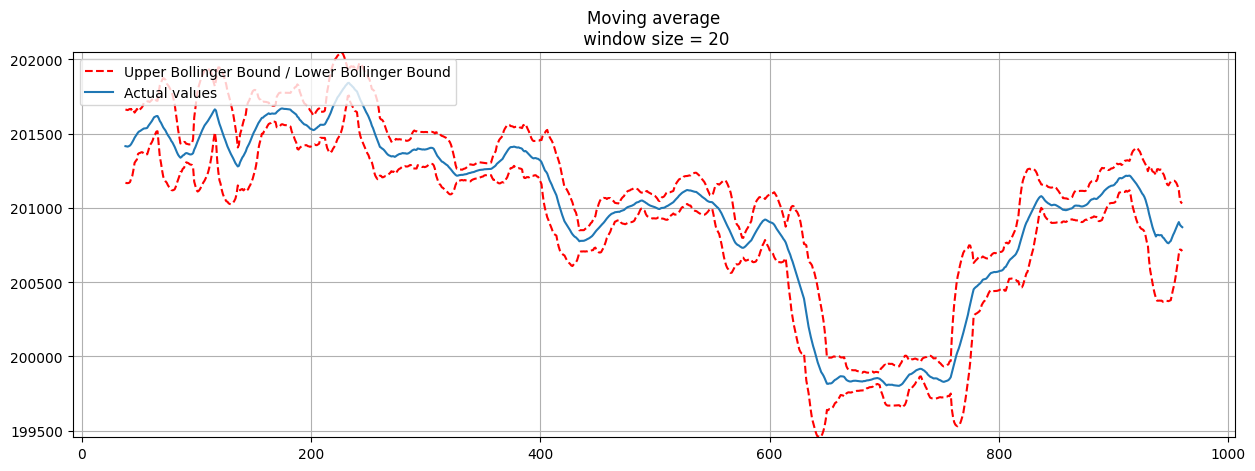

In [304]:
df = bollinger_bands
df.dropna(axis=0, inplace=True)


series = df['price']
scale = 2
window = 20
sma = series.rolling(window).mean()
deviation = series.rolling(window).std()
lower_bound = sma - scale * deviation
upper_bound = sma + scale * deviation

# 绘制布林带图
plt.figure(figsize=(15,5))
plt.plot(upper_bound, "r--", label="Upper Bollinger Bound / Lower Bollinger Bound")
plt.plot(lower_bound, "r--")
    
plt.title("Moving average\n window size = {}".format(window))
plt.plot(sma, label="Actual values")
plt.ylim(lower_bound.min() - 1, upper_bound.max() + 1)
plt.legend(loc="upper left")
plt.grid(True)

In [339]:
#  !!!!!
liquidity_data = liquidity_raw
# liquidity_data
swaps1 = swaps
# swaps1

In [340]:
tick_index_data = liquidity_data["tick"]
# 为了方便 我直接拿tick来算了
bollinger_bands = utils.calculate_bollinger_bands(tick_index_data,window_size=10, num_std=3)
# bollinger_bands
# 选取tick上限和下限
tickLower = bollinger_bands.iloc[-1][0]
tickUpper = bollinger_bands.iloc[0][0]

# 计算fee
pool_id = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
decimal0 = 6
decimal1 = 18
# 初始头寸的美元价值
initial_position = 10000

# 选定时间
begin = datetime(2023, 3, 19)
end = datetime.now()

# 计算价格范围
tickLower = lower_tick
tickUpper = upper_tick
price_low = utils.tickIndex2Price(tickLower)
price_upper = utils.tickIndex2Price(tickUpper)
print("this is the lower price: ", price_low)
print("this is the upper price: ", price_upper)
# 先把tick price转换成sqrtX96的形式
sqrt_p_lower = (price_low ** 0.5) * (2 ** 96)
sqrt_p_upper = (price_upper ** 0.5) * (2 ** 96)
sqrt_p_lower_f = '{:.0f}'.format(sqrt_p_lower)
sqrt_p_upper_f = '{:.0f}'.format(sqrt_p_upper)
# 获取swaps
# swaps = query.query_swaps(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id, sqrtPriceX96_gte=sqrt_p_lower_f, sqrtPriceX96_lte=sqrt_p_upper_f)
# swaps = query.query_swaps(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id)

swaps1 = swaps
swaps1['tick'] = swaps1['tick'].astype(int)
# 筛选swaps的条件：swap后最终的tick在我们的头寸tick之内
condition = (swaps1['tick'] > tickLower) & (swaps1['tick'] < tickUpper)
# 筛选
print("total swaps: \n", swaps.shape[0])
swaps1 = swaps1[condition]
print("total swaps in range: \n", swaps1.shape[0])


this is the lower price:  492970813.3745002
this is the upper price:  578501980.8507955
total swaps: 
 18000
total swaps in range: 
 15070


In [341]:
liquidity_data = liquidity_raw
# !!!
# 竟然只有20个在range内，可能需要调整一下固定长度
# 计算fee
# 先计算liquidity的大小
# 初始头寸的美元价值为10000usdc
# liquidity_data = query.query_liquidity(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id)
liquidity_data["sqrtPrice"] = liquidity_data["sqrtPrice"].astype(float)
liquidity_data["liquidity"] = liquidity_data["liquidity"].astype(float)
liquidity_data["real_price"] = liquidity_data["sqrtPrice"].astype(float).apply(lambda x: utils.sqrtPrice2Price(x))
liquidity_data["currentTickIndex"] = liquidity_data["real_price"].astype(float).apply(lambda x: utils.price2TickIndex(x))
upperPrice = utils.tickIndex2Price(upper_tick)
lowerPrice = utils.tickIndex2Price(lower_tick)

initial_position = 100000
position_token0_amount = initial_position / 2
real_price_token1 = 1 / (utils.price2RealPrice(liquidity_data["real_price"].iloc[-1], 6, 18))
position_token1_amount = 5000  / real_price_token1
liquidity = utils.calculateLiquidity(token0_amount=position_token0_amount, token1_amount=position_token1_amount, price_low=lowerPrice, price_upper=upperPrice,decimal0=decimal0, decimal1=decimal1)
liquidity_data["ratio"] = liquidity / liquidity_data["liquidity"]

liquidity_data = liquidity_data[["periodStartUnix", "ratio"]]
liquidity_data = liquidity_data.rename(columns={"periodStartUnix": "timestamp", "ratio": "ratio"})
# 先排序
swaps1["timestamp"] = swaps1["timestamp"].astype(int)
swaps1 = swaps1.sort_values(by="timestamp")
liquidity_data = liquidity_data.sort_values(by="timestamp")
# 找liquidity data只时间最接近的来合并
merged_data = pd.merge_asof(
    swaps1,
    liquidity_data[["timestamp", "ratio"]],
    on="timestamp",
    direction="nearest"
)

# 计算手续费
liquidity_data["ratio"] = liquidity_data["ratio"].astype(float)
merged_data['amount0'] = merged_data['amount0'].astype(float).apply(lambda x: max(0, x))
merged_data['amount1'] = merged_data['amount1'].astype(float).apply(lambda x: max(0, x))

merged_data["fee0"] = merged_data["amount0"] * merged_data['ratio'] * 0.0005
fee0_sum = merged_data["fee0"].sum()

merged_data["fee1"] = merged_data["amount1"] * merged_data['ratio'] * 0.0005
fee1_sum = merged_data["fee1"].sum()

print(fee0_sum)
print(fee1_sum)

12.670165609991647
0.0073976965303048595


/var/folders/sg/7v3zg8sx3y955mr8pjlkqmkw0000gn/T/ipykernel_4073/2389014028.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swaps1["timestamp"] = swaps1["timestamp"].astype(int)


In [342]:
from investMetric import metric
reload(metric)
begin = datetime(2023, 3, 19)
end = datetime.now()
days = (end - begin).days
metric.metric(merged_data=merged_data, token0_amount=token0_amount, token1_amount=token1_amount, begin=begin, end=end, decimal0=decimal0, decimal1=decimal1, rf=rf, l=l)
print(fee0_sum)
print(fee1_sum)

** volatility =  1.6049197811810449e+34
** roi =  0.023265526987319207
** sharpe_ratio =  0.023265526987319207
** max_drawdown =  0.006225642298622253
| Output       |       Value |
|--------------+-------------|
| volatility   | 1.60492e+34 |
| roi          | 0.0232655   |
| sharpe_ratio | 0.0232655   |
| max_drawdown | 0.00622564  |
12.670165609991647
0.0073976965303048595
